In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report

import math
from numpy.linalg import inv
from PIL import Image
import glob
import scipy
import imageio
from scipy import misc
import numpy as np

In [2]:
dic_label = {'Alef':0, 'Be':1,'Ain':2,'Dal':3,'Fe':4,'Ghe':5,'Ha':6,'Hamze':7,
            'He':8,'Kaf':9,'Lam':10,'Mim':11,'Noon':12,'Re':13,'Sad':14,
            'Sin':15,'Ta':16,'Vav':17,'Ya':18}

In [3]:
def normalization(matrix):
    
    sc = StandardScaler()  
    norm_matrix = sc.fit_transform(matrix)  

    return norm_matrix

In [4]:
#i use the LOCI algorithm to extract features from image 
def feature_extraction(matrix,filename):
    
    b0 = 0
    b1 = 0
    b2 = 0
    b3 = 0
    filename = filename
    B = matrix
    feature_vector = 81*[0]

    for i in np.ndindex(B.shape):
        row,col = i
        
        if B[row][col]==0:
            
            for j in range(col,(B.shape[1]-1)):
                if B[row][j] == 0 and B[row][j+1]==255: #go right
                    b0 += 1
            for j in range(col,0,-1):
                if B[row][j] == 0 and B[row][j-1]==255: #go left
                    b2 += 1 
            for j in range(row,(B.shape[0]-1)):  #go down
                if B[j][col] == 0 and B[j+1][col] ==255:
                    b3 +=1
            for j in range(row,0,-1): #go up
                if B[j][col] == 0 and B[j-1][col] ==255:
                    b1 +=1
                    
            s = np.array([b0,b1,b2,b3]) #[b0,b1,b2,b3]
            b0 = 0
            b1 = 0
            b2 = 0
            b3 = 0
            s = np.where(s>2,2,s)      #if the number of 1 more that 2 set 2
            mabna = s[3]*(3**0) + s[2]*(3**1) + s[1]*(3**2) + s[0]*(3**3)   #convert to 10 base
            feature_vector[mabna] += 1 

    label = filename[9:]  ## set label
    label = label.split('.') 
    label = label[0]
    label = dic_label[label]
    
    feature_vector = np.append(feature_vector,label)

    return feature_vector


In [5]:
def get_means(dataset):
    
    for item in dataset.keys():
        
        values_of_class = dataset.get(item)
        mean_of_class = np.mean(values_of_class,axis=0)
        cov = get_covariance(values_of_class,mean_of_class)
        d = dict_of_means(item,mean_of_class)
        c = dict_of_covs(item,cov)

    
    return d,c

In [6]:
means = {}

def dict_of_means(item,mean_of_class):
    
    vector = mean_of_class
    if item not in means:
        means[item] = []
    means[item].append(vector)
    
    return means

In [7]:
covariance={}

def dict_of_covs(item,cov):
    vector = cov
    if item not in covariance:
        covariance[item] = []
    covariance[item].append(vector)
    return covariance

In [8]:
def get_covariance(values,mu):
    
    covmatrix = np.cov(np.stack(values).T)
    
    return covmatrix

In [9]:
def make_dataset():
    
    image_list = []
    data_set = []
    separated = {}
    dataset = np.empty((0,82),int)

    for filename in glob.glob('pattern2/*.jpg'): 
        
        matrixofimg = imageio.imread(filename)
        matrixofimg = np.where(matrixofimg>210,255,matrixofimg)
        matrixofimg = np.where(matrixofimg<=10,0,matrixofimg)
        
        data_set = feature_extraction(matrixofimg,filename)
        dataset = np.append(dataset,[data_set],axis=0)
    
    return dataset

In [10]:
def dimension_reduction(dataset_x):
    
    tsvd = TruncatedSVD(n_components=13)
    X_sparse_tsvd = tsvd.fit(dataset_x).transform(dataset_x)

    print('explained_variance_ratio_[0:13]',tsvd.explained_variance_ratio_[0:13].sum())
    
    return X_sparse_tsvd

In [11]:
def mean_covariance(data):
    means = {}
    covariance = {}
    dictionary_of_means,dictionary_of_cov = get_means(data)
    mu=dictionary_of_means
    covariance=dictionary_of_cov  
    return mu,covariance

In [12]:
separated = {}

def separateByClass(dataset):

    for item in dataset:
        if item[-1] not in separated:
            separated[int(item[-1])] = []
        separated[int(item[-1])].append(item[0:-1])
    return separated

In [13]:
#Bayesian Classifier 
def calculate_probe(x,mu,cov):
    x = x
    mu = mu
    cov = cov
    l = len(mu)
    y_pred = []
    for item in x:
        prob_arr = []

        for i in range(l):
            
            sub = np.subtract(item,mu[i]) #x-mu 1*10
            icov = np.linalg.inv(cov[i][0])
            prob = np.matmul(sub,icov)
            prob1 = -(np.matmul(prob,sub.T))
            prob1 = float(prob1)
            prob_arr = np.append(prob_arr,[prob1],axis=0)
            prob_arr = prob_arr.astype('int64')
 
        label = np.argmax(prob_arr)
        y_pred = np.append(y_pred,[label],axis=0)

    return y_pred

In [37]:
def test_train_split(dataset):
        
    x = dataset[:,0:81]
    y = dataset[:,-1]
    
    x = normalization(x)
    x = dimension_reduction(x)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30,random_state = 42,stratify = y)    
    y_train1 = np.reshape(y_train,(len(y_train),1))
    
    dataset_train = np.hstack((x_train,y_train1))
    
    dict_of_x_train = separateByClass(dataset_train)

    return dict_of_x_train,x_train,y_train,x_test,y_test

In [15]:
dataset = make_dataset()

In [38]:
total_acc = []
iteration = 0
while iteration <= 5:
    
    dict_of_x_train,x_train,y_train,x_test,y_test = test_train_split(dataset)
    means = {}
    covariance = {}
    dict_of_mean,dictionary_of_cov = get_means(dict_of_x_train)
    y_pred = calculate_probe(x_test,dict_of_mean,dictionary_of_cov)
    accuracy = np.mean(y_pred == y_test)
    
    total_acc = np.append(total_acc,[accuracy],axis=0)
    iteration += 1
    
print(total_acc)
print("\n Total accuracy: ", np.mean(total_acc))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


explained_variance_ratio_[0:13] 0.6773726178130418
explained_variance_ratio_[0:13] 0.6773688022535338
explained_variance_ratio_[0:13] 0.6773572837061085
explained_variance_ratio_[0:13] 0.6773775655635367
explained_variance_ratio_[0:13] 0.6773797700234061
explained_variance_ratio_[0:13] 0.6773655038017852
[0.93023256 0.93023256 0.93023256 0.93023256 0.93023256 0.93023256]

 Total accuracy:  0.9302325581395349


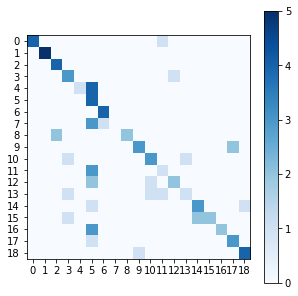

In [30]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
plt.xticks(range(19))
plt.yticks(range(19))
plt.colorbar()
plt.show()